**This code was adapted from [Alexander Held's "Example of a differentiable analysis" repository](https://github.com/alexander-held/differentiable-analysis-example/)**

In [3]:
from jax import grad, vmap, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
plt.rcParams.update({
    "font.size": 14,
    "figure.figsize": (7, 5),
    "figure.dpi": 100})

### Introduction

We have two processes:

- signal `S`,
- background `B`,

and we observe events generated from these processes.
The observation consist of measuring a single observable.
We have Monte Carlo predictions in the form of events generated for both processes, which tell us how many events we observe as a function of the observable $x$.

We want to do a single-bin counting experiment to establish the presence of the signal process.
The significance calculation for this is found below.
To maximize the significance, this toy analysis introduces a cut.
We only let events with an observable $x>c$ enter our bin, where $c$ is a cut value we intend to optimize.

### Data generation and visualization
The background and signal events in this toy case have slightly different values of the observable $x$ on average, but the spread of the background along the observable is quite large. 

In [4]:
nBg  = 8000
nSig = 300
background = np.random.normal(40, 10, nBg)
signal = np.random.normal(50, 5, nSig)

bins = jnp.linspace(0, 80, 40)

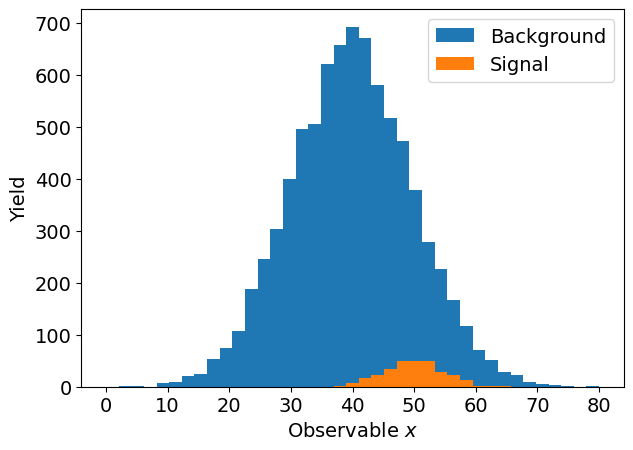

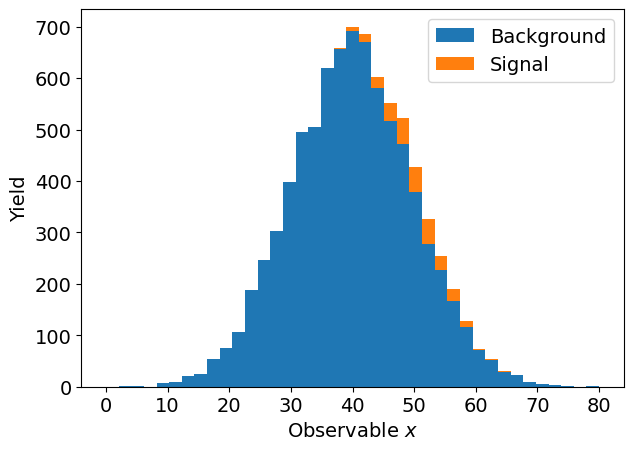

In [5]:
fig, ax = plt.subplots()
alpha = 1.0
ax.hist(background, bins=bins, alpha=alpha, label=["Background"])
ax.hist(signal, bins=bins, alpha=alpha, label=["Signal"])
ax.set_xlabel(r"Observable $x$")
ax.set_ylabel("Yield")
ax.legend(loc="best")
fig.savefig("plots/signal_background_shapes.png")

fig, ax = plt.subplots()
ax.hist([background, signal], bins=bins, stacked=True, label=["Background", "Signal"])
ax.set_xlabel(r"Observable $x$")
ax.set_ylabel("Yield")
ax.legend(loc="best")
fig.savefig("plots/signal_background_stacked.png");

### Calculate significance for given cut and scan
This significance is given by the amount of signal and background events in the bin as 
$\sqrt{2(S+B) \log(1+\frac{S}{B}) -2S}$.
Expand $\log(1+y) \approx y-\frac{y^2}{2}$ to recover $\frac{S}{\sqrt{B}}$.

In [3]:
def significance(S, B):
    """calculate the significance according to the formula above"""
    return jnp.sqrt(2*((S+B)*jnp.log(1+S/B)-S))

def get_significance(cut, S, B):
    """calculate the significance at a given cut value for signal and background events"""
    S_cut = len(S[S>cut])
    B_cut = len(B[B>cut])
    return significance(S_cut, B_cut)

Let's calculate as a baseline the significance for when the cut is $c=0$, so we let all events $x>0$ pass the cut.

In [4]:
baseline_significance = get_significance(0, signal, background)
print("the baseline significance is", baseline_significance, "σ")

the baseline significance is 3.3335216 σ


In this example it is straightforward to just scan for the optimal setting, let's do that before we use any autodiff. 

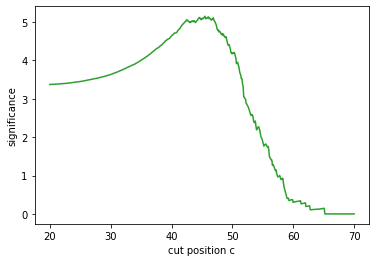

In [5]:
cuts = jnp.linspace(20, 70, 500)
significances = [get_significance(cut, signal, background) for cut in cuts]

plt.plot(cuts, significances, c="C2")
plt.xlabel("cut position c")
plt.ylabel("significance");

Seems like we should use a cut of $x>45$ or so.
Now for the autodiff version.

### Let's calculate a gradient
With `jax` we get the gradient of `get_significance` by just calling `grad()`.
The argument `argnums=0` means that we want the gradient wrt. the first argument, which is the cut value.

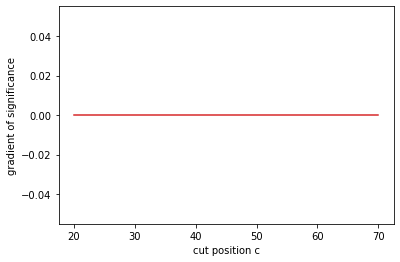

In [6]:
grad_significance = grad(get_significance, argnums=0)

# let's calculate the derivative for a few values
significances_prime = [grad_significance(cut, signal, background) for cut in cuts]
plt.plot(cuts, significances_prime, c="C3");
plt.xlabel("cut position c")
plt.ylabel("gradient of significance");

This did not quite work out.
The problem here is that the significance function is actually flat almost everywhere, and the gradient is only non-zero exactly where events are located.
The significance changes as single events leave the bin that we use for the measurement, so it changes at the positions of all the events.
We need something else to properly do what we want.
To confirm the above, let's have a very zoomed in look at the significance as a function of the cut position.

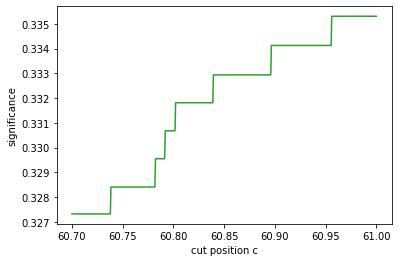

In [7]:
cuts_zoomed = jnp.linspace(60.7, 61.0, 500) # zoom in to see step function behavior
significances_zoomed = [get_significance(cut, signal, background) for cut in cuts_zoomed]
plt.plot(cuts_zoomed, significances_zoomed, c="C2")
plt.xlabel("cut position c")
plt.ylabel("significance");

### Making it work
Instead of working with the non-differential cut operation, let's replace it by something differentiable.
We give weights to all our events.
Those weights should be `1` in the limit where the events are very far above the cut, and `0` if they are very far below the cut.

We can use a sigmoid $1 / [1+e^{-\alpha(x-c)}]$ to calculate the weight, where $c$ is the cut value and $\alpha$ a parameter that adjust the steepness.
Larger values of $\alpha$ make the function steeper in the transition region around the cut.

In [8]:
def yield_after_cut(x, c):
    """calculate the number of events passing a certain cut"""
    steepness = 1 # too large -> NaNs later on...
    passed = 1/(1+jnp.exp(-steepness*(x-c)))
    return passed

We can visualize the weight as a function of observable for a given cut value.

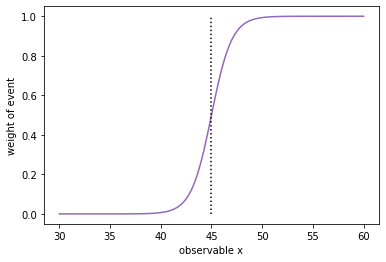

In [9]:
x = jnp.linspace(30, 60, 100)
example_cut = 45
y_pass = yield_after_cut(x, example_cut)

plt.plot(x, y_pass, c="C4")
plt.plot([example_cut, example_cut], [0,1], ":", c="k")
plt.xlabel("observable x")
plt.ylabel("weight of event");

Let's define a new function to calculate the significance, but now instead of doing it by applying cuts we instead approximate cuts with the sigmoid approach and weights.
We can compare this way of calculating the significance to the approach using hard cuts from earlier.

the optimal cut is c = 44.849697


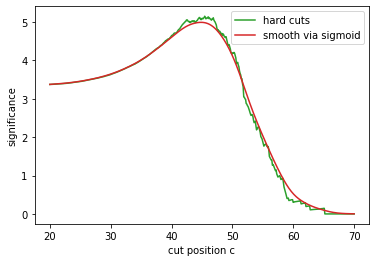

In [10]:
def get_significance_smooth(cut, S, B):
    """calculate significance for a given cut, but now approximate the cut with a sigmoid"""
    S_pass = yield_after_cut(S, cut)
    B_pass = yield_after_cut(B, cut)
    sum_S_weighted = jnp.sum(S_pass)
    sum_B_weighted = jnp.sum(B_pass)
    return significance(sum_S_weighted, sum_B_weighted)

cuts_smooth = jnp.linspace(20, 70, 500)
significances_smooth = jnp.asarray([get_significance_smooth(cut, signal, background) for cut in cuts_smooth])

plt.plot(cuts, significances, label="hard cuts", c="C2")
plt.plot(cuts_smooth, significances_smooth, label="smooth via sigmoid", c="C3")
plt.xlabel("cut position c")
plt.ylabel("significance")
plt.legend();

print("the optimal cut is c =", cuts_smooth[jnp.argmax(significances_smooth)])

The smooth version seems to be a decent approximation.
We can in principle improve it by increasing the steepness $\alpha$, but run into some `NaN` issues in the next step (insights welcome of how to solve this, we can already introduce them in the ste above be `@jit`-ing the function).

Now let's calculate the gradient of the smooth function above, and evaluate it for a few cut values.

In [11]:
sig_gradient_function = grad(get_significance_smooth, argnums=0)
sig_prime_smooth = jnp.asarray([sig_gradient_function(cut, signal, background) for cut in cuts_smooth])

The big moment has come!
Time to take a look at the results.

intercepts of the gradient with zero are located at [44.849697]


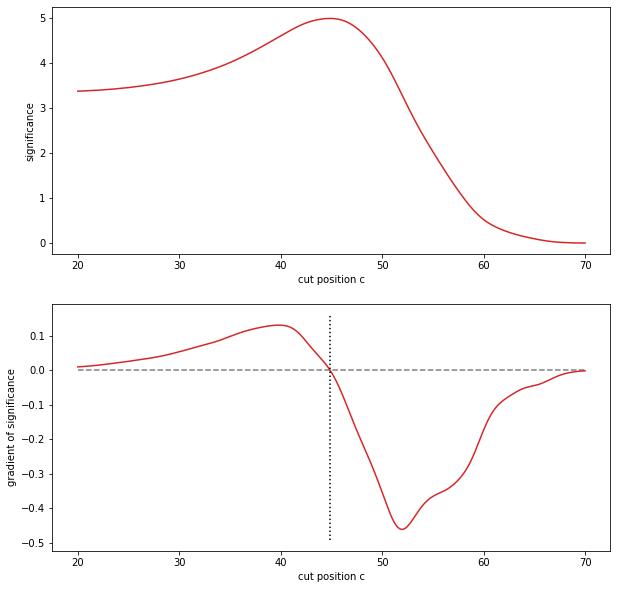

In [12]:
# draw significance again
_ = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(cuts_smooth, significances_smooth, c="C3")
plt.xlabel("cut position c")
plt.ylabel("significance")

# add gradient
plt.subplot(2,1,2)
plt.plot([20, 70], [0,0], "--", c="grey")
plt.plot(cuts_smooth, sig_prime_smooth, c="C3")

def get_intercept_indices(arr):
    """find where an array of values intercepts zero"""
    intercepts = []
    for i in range(len(arr)):
        # check if sign changed, meaning zero was crossed
        if arr[i]*arr[i+1] < 0:
            # pick side closer to zero and return index
            if jnp.abs(arr[i]) > jnp.abs(arr[i+1]):
                intercepts.append(i+1)
            else:
                intercepts.append(i)
    return jnp.asarray(intercepts)
            
intercepts = get_intercept_indices(sig_prime_smooth)
cut_values = jnp.asarray([cuts_smooth[intercept] for intercept in intercepts])

print("intercepts of the gradient with zero are located at", cut_values)

xmin, xmax, ymin, ymax = plt.axis()

for cval in cut_values:
    plt.plot([cval, cval], [ymin, ymax], ":", c="k")
plt.xlabel("cut position c")
plt.ylabel("gradient of significance");

We can find the maximum significance at the point where the gradient of the significane intercepts zero (and could in principle check the second derivative to make sure this is not a saddle point).

### Automatic analysis optimization

As a last step, let's write a simple gradient ascent function to find the point of maximum significance.
In the example below this is computationally far less efficient than a scan, but with a better implementation and a higher dimensional problem the approach really shines.

current position is 20.0 and the gradient is 0.009170567
current position is 31.289082 and the gradient is 0.06324105
current position is 44.84982 and the gradient is 5.9604645e-07
current position is 44.84982 and the gradient is 5.9604645e-07
final position is 44.84982


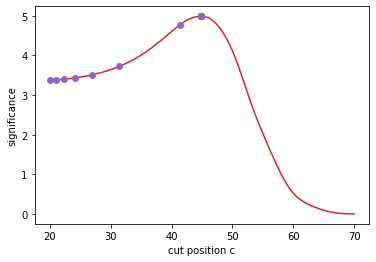

In [13]:
steps = 1000

c0 = 20.0 # initial position
alpha = 2 # step size

steps_taken = []

for i in range(steps):
    # reduce step size after a while
    if i%500 == 0 and i != 0:
        alpha = alpha/5
    grad_at_pos = sig_gradient_function(c0, signal, background)
    if i%250 == 0:
        print("current position is", c0, "and the gradient is", grad_at_pos)
    c0 = c0 + alpha*grad_at_pos
    if i%50 == 0:
        steps_taken.append(c0)

print("final position is", c0)

# calculate the significance at a few steps along the way to visualize
sig_at_steps = jnp.asarray([get_significance_smooth(step, signal, background) for step in steps_taken])

plt.plot(cuts_smooth, significances_smooth, c="C3")
plt.plot(steps_taken, sig_at_steps, "o", c="C4")
plt.xlabel("cut position c")
plt.ylabel("significance");